Ovo je prva obavezna bilježnica u okviru kolegija Dubinska analiza podataka. Cilj ove bilježnice je upoznati se sa skupom podataka i započeti njegovu obradu.

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# 1. Data dimensionality
U ovom poglavlju proći ću kroz podatke i opisati ih.

In [1]:
train=pd.read_csv("/kaggle/input/dapprojekt23/train.csv")

In [2]:
train.head()

,day,broken,total,label,machine_name,id
0,0,14,1467,0,AI10095,0
1,1,12,1866,0,AI10095,1
2,2,31,1586,0,AI10095,2
3,3,0,2020,0,AI10095,3
4,4,12,1588,0,AI10095,4


In [3]:
train.describe()

,day,broken,total,label,id
count,781572.000000,781572.000000,781572.000000,781572.000000,781572.000000
mean,278.420831,3.386302,2401.644072,0.002358,390785.500000
std,164.003486,17.752318,2471.317178,0.048503,225620.546633
min,0.000000,0.000000,-32631.000000,0.000000,0.000000
25%,137.000000,0.000000,713.000000,0.000000,195392.750000
50%,276.000000,1.000000,1665.000000,0.000000,390785.500000
75%,415.000000,3.000000,3320.000000,0.000000,586178.250000
max,671.000000,1518.000000,32279.000000,1.000000,781571.000000


Skup podataka sastoji se 781 152 podatka te ću nad njima donositi zaključak.

Vidim da se skup podataka sastoji od 6 različitih značajki:

**id**- oznaka jedinstvenog unosa u skupu podataka 

**day**-predstavlja dan proizvodnje, strojevi su radili 672 dana i ti dani su označeni brojevima u intervalu [0, 671]

**machine_name**-govori o imenu stroja, da ih znamo razlikovati jer nisu svi stojevi jednaki

**total**-predstavlja ukupan broj paketa pločica koji su proizvedeni

**broken**-predstavlja broj paketa sa slomljenim pločicama

**label**-ukazuje na moment u kojem je uočena anomalija i u kojem smo zaključili da se stroj pokvario

U nastavku ću se detaljnije posvetiti svakoj varijabli i napraviti korekcije za nju ako će iste biti potrebne

Pošto dataFrame ima svoj id i svoj način označavanja podataka maknuti ću varijablu *id* iz skupa podatka.

In [4]:
del train["id"]

In [5]:
train.isnull().values.any()

False

Vidimo da skup podataka ne sadrži NaN vrijednosti pa se ne trebamo brinuti o njima

Gore opisna tablica skupa podataka pokazuje da neki strojevi imaju negativne vrijednosti za ukupan broj proizvedenih paketa. Naravno to je nemoguće, pa ću iz skupa podataka maknuti sve unose koji sadrže te pogrešne podatke. Također maknuti ću i moguće pogrešne unose gdje bi broj paketa sa slomljenim pločicama bio veći od ukupnog broja paketa. Također spomenuto je u opisu zadataka da u prvih 365 dana nema anomalija tako da ako postoje takvi podatci njih ću isto izbaciti.

In [6]:
train=train.loc[train["total"]>0]
train=train.loc[train["broken"]<=train["total"]]
train.drop(train[(train.day < 365) & (train.label == 1)].index, inplace=True)
train.describe()

,day,broken,total,label
count,774640.000000,774640.000000,774640.000000,774640.000000
mean,278.532269,3.407298,2427.700400,0.002379
std,164.000091,17.828950,2444.038233,0.048719
min,0.000000,0.000000,1.000000,0.000000
25%,138.000000,0.000000,735.000000,0.000000
50%,276.000000,1.000000,1684.000000,0.000000
75%,415.000000,3.000000,3341.000000,0.000000
max,671.000000,1518.000000,32279.000000,1.000000


Ostalo je 774640 unosa što znači da je bilo oko 6500 pogrešnih unosa.

Prije bilo kakvog rada s podatcima potrebno je promijeniti vrstu podataka svim značajkama u one koje uzimaju manje memorije tako da bi rad sa skupom podataka bio efikasniji.

In [7]:
train.dtypes

day              int64
broken           int64
total            int64
label            int64
machine_name    object
dtype: object

In [8]:
train=train.astype({"machine_name":"category"})
train=train.astype({"day":"uint16"})
train=train.astype({"broken":"uint16"})
train=train.astype({"total":"uint16"})
train=train.astype({"label":"uint8"})
train.dtypes

day               uint16
broken            uint16
total             uint16
label              uint8
machine_name    category
dtype: object

Jedina ne brojčana značajka je *machine_name* pa treba vidjeti koliko ima unikatnih i koji su unikatni strojevi, to koliko se strojeva uopće kvari.

In [9]:
strojevi=train.machine_name.unique()
pokvareni_strojevi=train.loc[train["label"]==1].machine_name.unique()
print("Skup podataka sadrži "+str(len(strojevi))+" unikatnih stojeva, a "+str(len(pokvareni_strojevi))+" se barem jednom pokvari.")

Skup podataka sadrži 1442 unikatnih stojeva, a 264 se barem jednom pokvari.


# 2. Features distribution
U ovom poglavlju prikazat ću distribucije bitnih brojčanih značajki da vidim postoje li kakvi outlieri.

<AxesSubplot:>

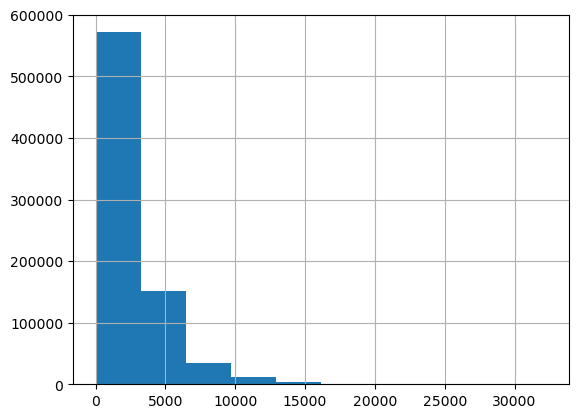

In [10]:
train.total.hist()

Vidim da je većina podataka manja od 15000 pa ćemo ostale podatke maknuti jer su oni outlieri i mogli bi loše utjecati na model.

Uz običnu distribuciju pokazat ću i distribuciju logoritmiziranih podataka za varijable total i broken.

<AxesSubplot:title={'center':'Histogram za znacajku broken-logoritmizirani podatci'}, ylabel='Frequency'>

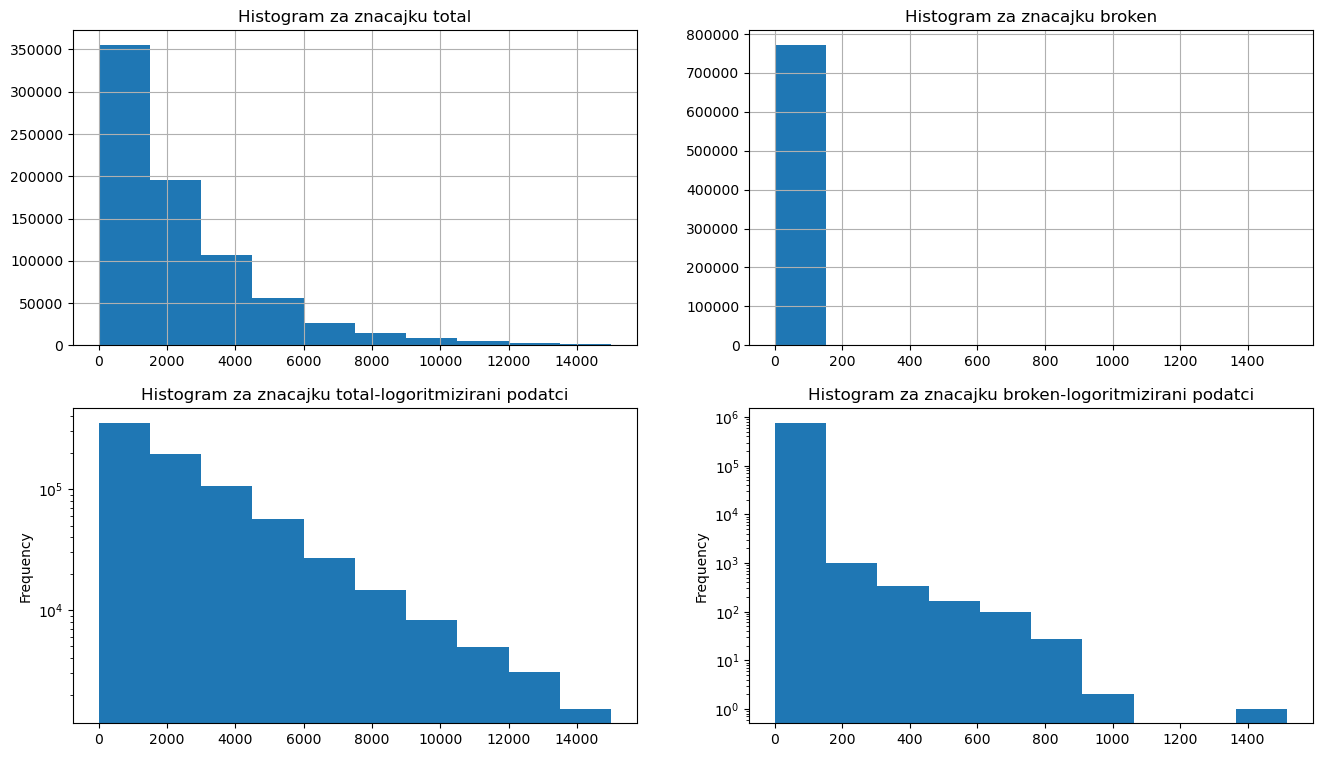

In [11]:
train=train.loc[train['total']<=15000]

plt.figure(figsize=(16, 9))
plt.subplot(2, 2,1)
plt.title("Histogram za znacajku total")
train.total.hist()
plt.subplot(2, 2,2)
plt.title("Histogram za znacajku broken")
train.broken.hist()

#log skala
plt.subplot(2, 2,3)
plt.title("Histogram za znacajku total-logoritmizirani podatci")
train.total.plot(kind='hist',logy=True)
plt.subplot(2, 2,4)
plt.title("Histogram za znacajku broken-logoritmizirani podatci")
train.broken.plot(kind='hist', logy=True)

# 3. Missing data

Trebali bi imati podatke za svaki dan jer strojevi rade neprekidno, za slučaj da fale podatci za neki radni dan stroj popunit ćemo to podatke dolje napisanom funkcijom.

Kod ispod za svaki stroj gleda postoje li dani u kojima nema podataka, ako postoje onda se uzima prosjek od dana prij i kasnije, ako nije bilo anomalije u radu, ili ako je bilo anomalije u oba dana, inače se upisuje medijan za total i za broken te se za te podatke smatra da stoj nije bio u anomaliji.

In [12]:
strojevi=train.machine_name.unique()
dani=range(0,672)
data_to_be_appended=pd.DataFrame(columns=['day', 'broken', 'total', 'label', 'machine_name'])

i=1
for stroj in strojevi:
    stroj_dani=train.loc[train['machine_name']==stroj].day.unique()
    dani_bez_podataka=np.setdiff1d(np.asarray(dani), np.asarray(stroj_dani))
    machine_data=train.loc[(train['machine_name']==stroj)]
    i+=1
    for dan in dani_bez_podataka:
        total=abs(int(np.random.normal(loc=machine_data.total.mean(),
                                       scale=machine_data.total.std())))
        broken=abs(int(np.random.normal(loc=machine_data.broken.mean(),
                                        scale=machine_data.broken.std())))
        
        while broken>=total:
            total=abs(int(np.random.normal(loc=machine_data.total.mean(),
                                       scale=machine_data.total.std())))
            broken=abs(int(np.random.normal(loc=machine_data.broken.mean(),
                                        scale=machine_data.broken.std())))
        
        
        day_before=machine_data.loc[(machine_data['day']==dan-1)]
        day_after=machine_data.loc[(machine_data['day']==dan+1)]

        if day_before.empty or day_after.empty or day_before.label.sum()!=day_after.label.sum():
            novi_red = {'day':dan, 'broken':broken,
                        'total':total, 'label':0, 
                        'machine_name':stroj}
            data_to_be_appended=data_to_be_appended.append(novi_red, ignore_index=True)
        else:
            broken=int((day_before.broken.sum()+day_after.broken.sum())/2)
            total=int((day_before.total.sum()+day_after.total.sum())/2)

            novi_red = {'day':dan, 'broken':broken,
                        'total':total, 'label':day_before.label.sum(), 
                        'machine_name':stroj}
            data_to_be_appended=data_to_be_appended.append(novi_red, ignore_index=True)

    if i%100==0:
        print("Ovo je stroj "+str(i))
            
train.info()     

Ovo je stroj 100
Ovo je stroj 200
Ovo je stroj 300
Ovo je stroj 400
Ovo je stroj 500
Ovo je stroj 600
Ovo je stroj 700
Ovo je stroj 800
Ovo je stroj 900
Ovo je stroj 1000
Ovo je stroj 1100
Ovo je stroj 1200
Ovo je stroj 1300
Ovo je stroj 1400
<class 'pandas.core.frame.DataFrame'>
Int64Index: 772644 entries, 0 to 781571
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   day           772644 non-null  uint16  
 1   broken        772644 non-null  uint16  
 2   total         772644 non-null  uint16  
 3   label         772644 non-null  uint8   
 4   machine_name  772644 non-null  category
dtypes: category(1), uint16(3), uint8(1)
memory usage: 12.6 MB


In [13]:
train=train.append(data_to_be_appended, ignore_index=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969024 entries, 0 to 969023
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   day           969024 non-null  object
 1   broken        969024 non-null  object
 2   total         969024 non-null  object
 3   label         969024 non-null  object
 4   machine_name  969024 non-null  object
dtypes: object(5)
memory usage: 37.0+ MB


Vidimo da je sad 969024 podatka što je jednako 1442 * 672 što znači da sad imamo sve podatke. 

Ponovno treba promjeniti tipove podataka.

In [14]:
train=train.astype({"machine_name":"category"})
train=train.astype({"day":"uint16"})
train=train.astype({"broken":"uint16"})
train=train.astype({"total":"uint16"})
train=train.astype({"label":"uint8"})
train.dtypes

day               uint16
broken            uint16
total             uint16
label              uint8
machine_name    category
dtype: object

# 4. Visualizations

Ovdje ću vizualizirati podatke za mašine tako da pokažemo odnose između total i broken značajke. Napisao sam 2 funkcije:

getAnomalyLine()- ona vraća iznos efektivnosti za dani centil

visualizeEff()-crta graf koji prati efektivnost stroja kroz dan i označava crvenom točkom dane kad se dogodila anomalija. Također vuče liniju odabranog centila efektivnosti.

visualizeData()- pokazuje logoritmizirane podatke za total i broken, te povećano i drugom bojom ukazuje na anomaliju.

In [15]:
train=train.sort_values(by="day")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log


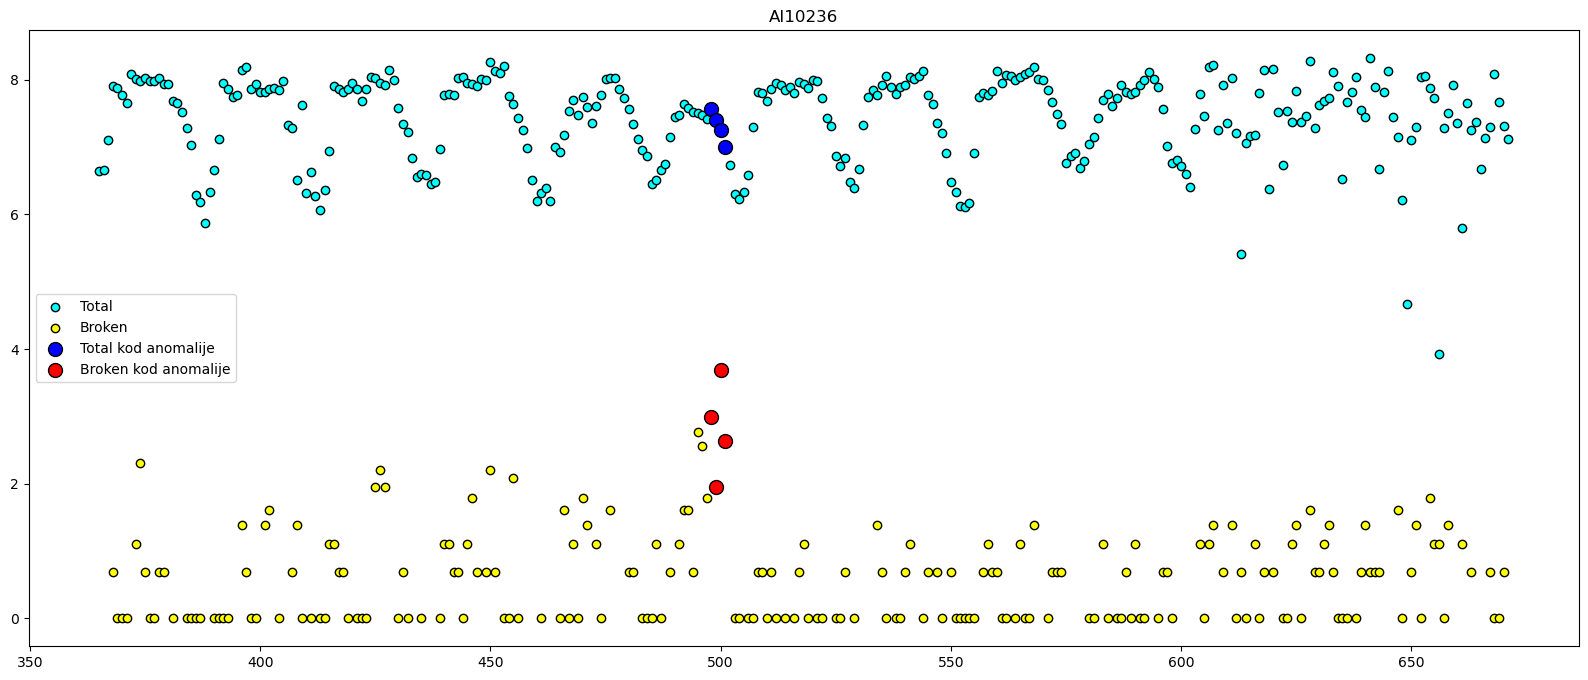

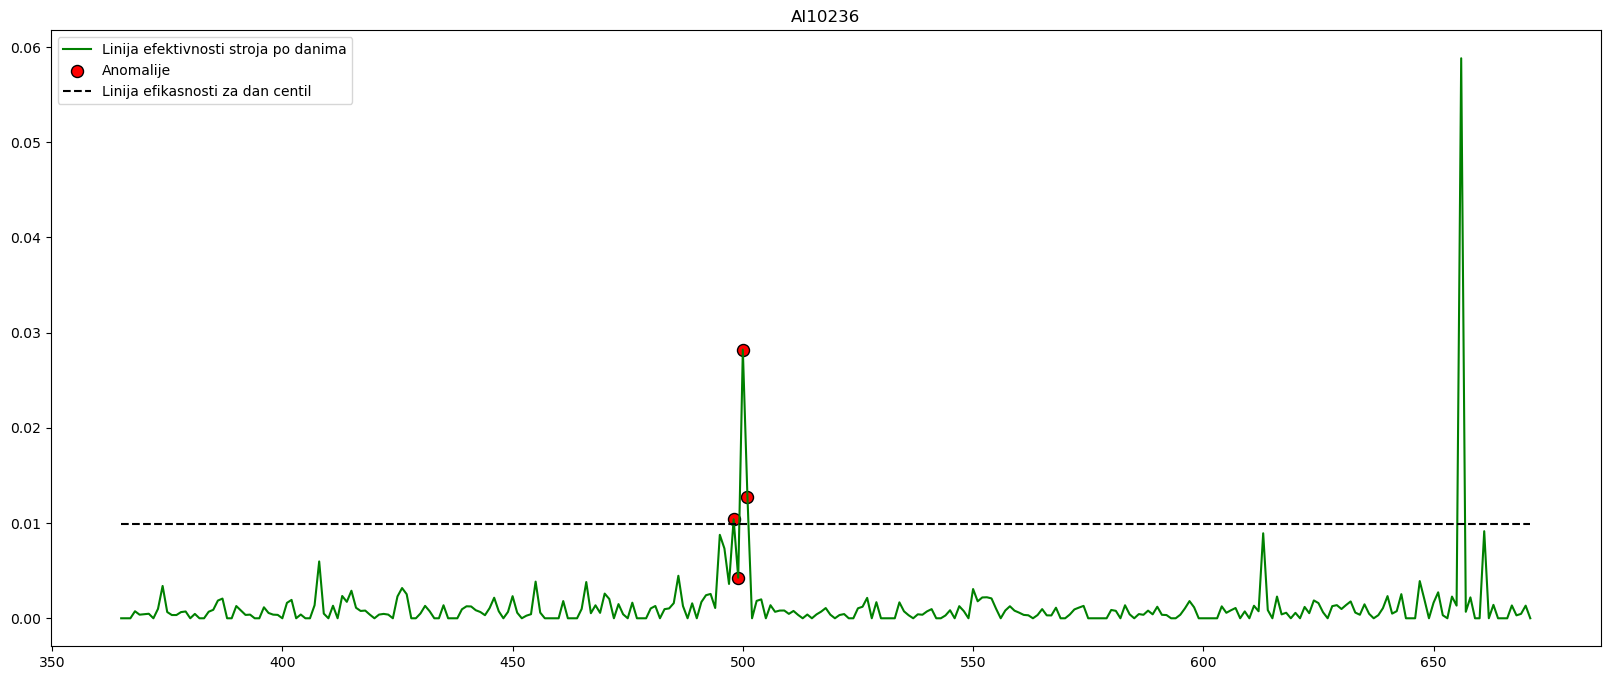

In [16]:
def getAnomalyLine(centil):
    eff_1=[]
    anomalije=train.loc[(train['label']==1)]

    for index, row in anomalije.iterrows():
        eff_1.append(row['broken']/row['total'])
    
    num_to_drop = int(len(eff_1) * centil)
    eff_1.sort()
    eff_1 = eff_1[num_to_drop:]
    
    return eff_1[0]

    

def visualizeEff(machine_name, centil):    
    machine_data=train.loc[(train['machine_name']==machine_name) & (train['day']>364)]
    plt.figure(figsize=(20, 8))
    anomalyLine=getAnomalyLine(centil)
    
    eff= []
    dani_anomalija= []
    anomalija_eff=[]
    line=[]
    dani=[]
    for index, row in machine_data.iterrows():
        eff.append(row['broken']/row['total'])
        line.append(anomalyLine)
        dani.append(row['day'])
        if row['label']==1:
            dani_anomalija.append(row['day'])
            anomalija_eff.append(row['broken']/row['total'])

    plt.title(machine_name)
    plt.plot(dani, eff, 'g-', label="Linija efektivnosti stroja po danima")
    plt.scatter(dani_anomalija, anomalija_eff, c='r', edgecolors= "black", s=75, label='Anomalije')
    plt.plot(dani, line, 'k--', label='Linija efikasnosti za dan centil')
    plt.legend(loc='best')
    plt.show()
    return

def visualizeData(machine_name):    
    machine_data=train.loc[(train['machine_name']==machine_name) & (train['day']>364)]
    plt.figure(figsize=(20, 8))
    
    total= []
    broken=[]
    anomalija_day=[]
    anomalija_total=[]
    anomalija_broken=[]
    for index, row in machine_data.iterrows():
        total.append(row['total'])
        broken.append(row['broken'])
        
        if row['label']==1:
            anomalija_total.append(row['total'])
            anomalija_broken.append(row['broken'])
            anomalija_day.append(row['day'])
        

    plt.title(machine_name)
    plt.scatter(range(365,365+len(total)), np.log(total), c='cyan', edgecolors= "black", label='Total')
    plt.scatter(range(365,365+len(broken)), np.log(broken), c='yellow',edgecolors= "black", label='Broken')
    
    plt.scatter(anomalija_day, np.log(anomalija_total), c='b', s=100, edgecolors= "black", label='Total kod anomalije')
    plt.scatter(anomalija_day, np.log(anomalija_broken), c='r', s=100, edgecolors= "black", label='Broken kod anomalije')
    
    plt.legend(loc='best')
    plt.show()
    return

visualizeData('AI10236')
visualizeEff('AI10236', 0.5)

# 5. Anomaly categorization

Ovdje ću sad prikazati neke zanimljive grafove s kategoriziranim anomalijama. 

Dva obrasca prikazivanja anomalija koja sam ja uočio su,

**Nepopravljivost**- kad se stroj pokvari i onda se ne popravi nego nastavlja raditi pokvaren

**Obična anomalija**-stroj taj dan ima uočivo više slomljenih paketa iz čega se može zaključiti da je to anomalija

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log


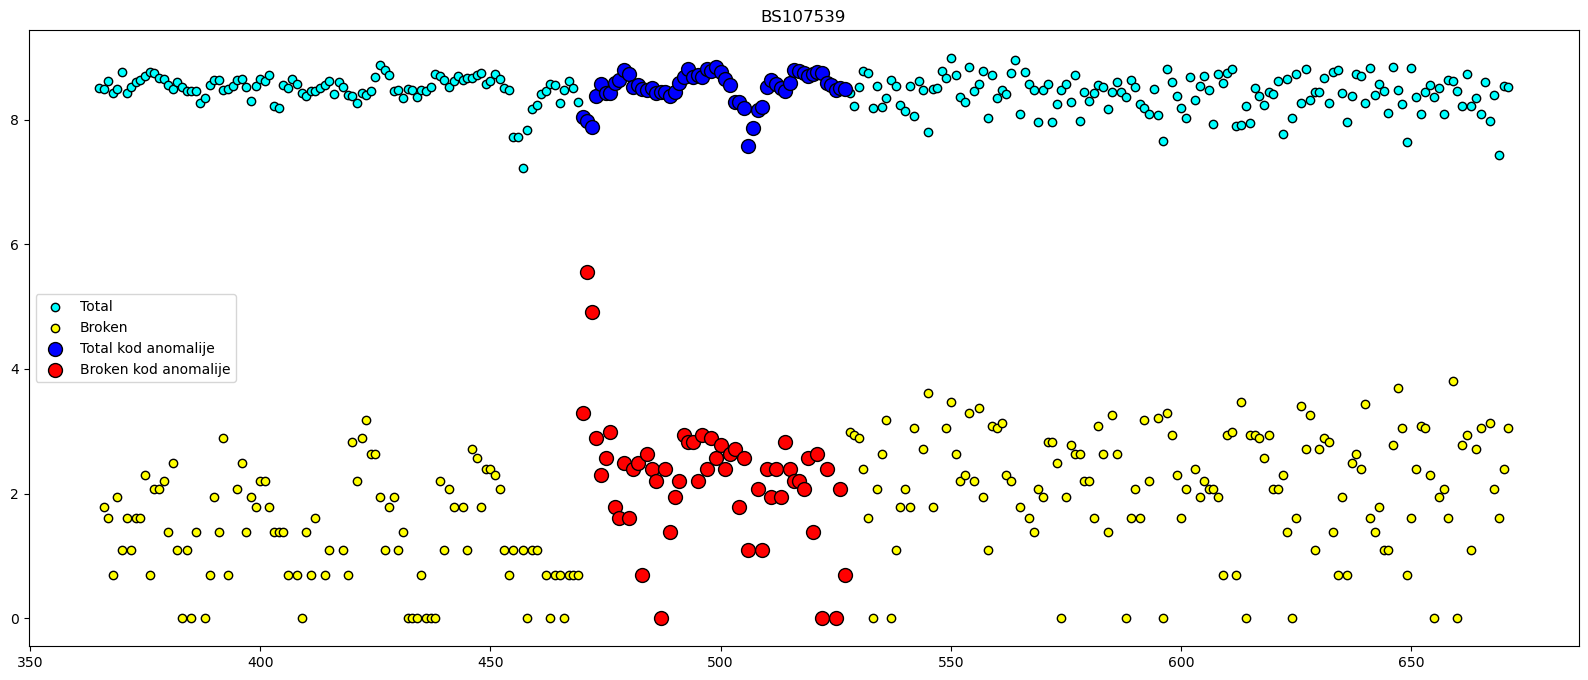

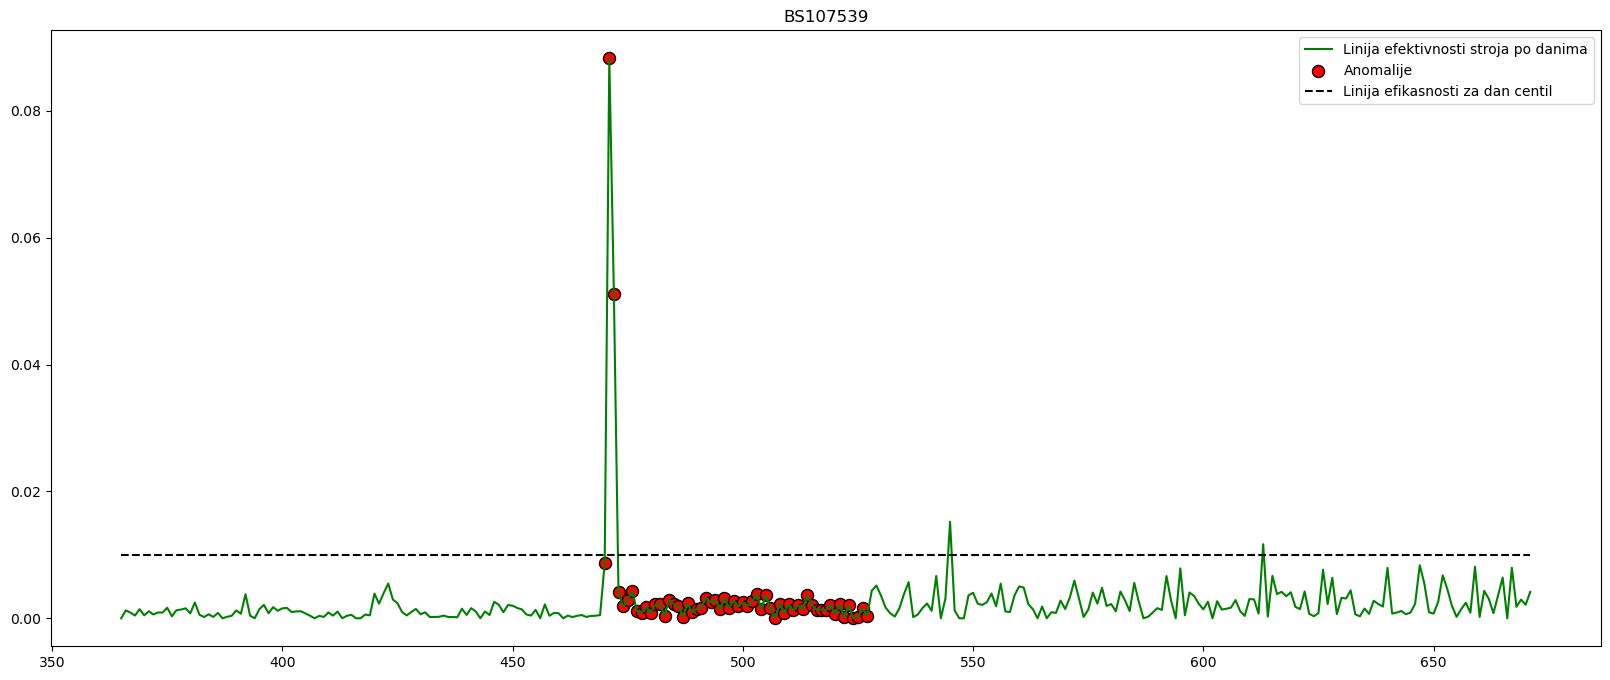

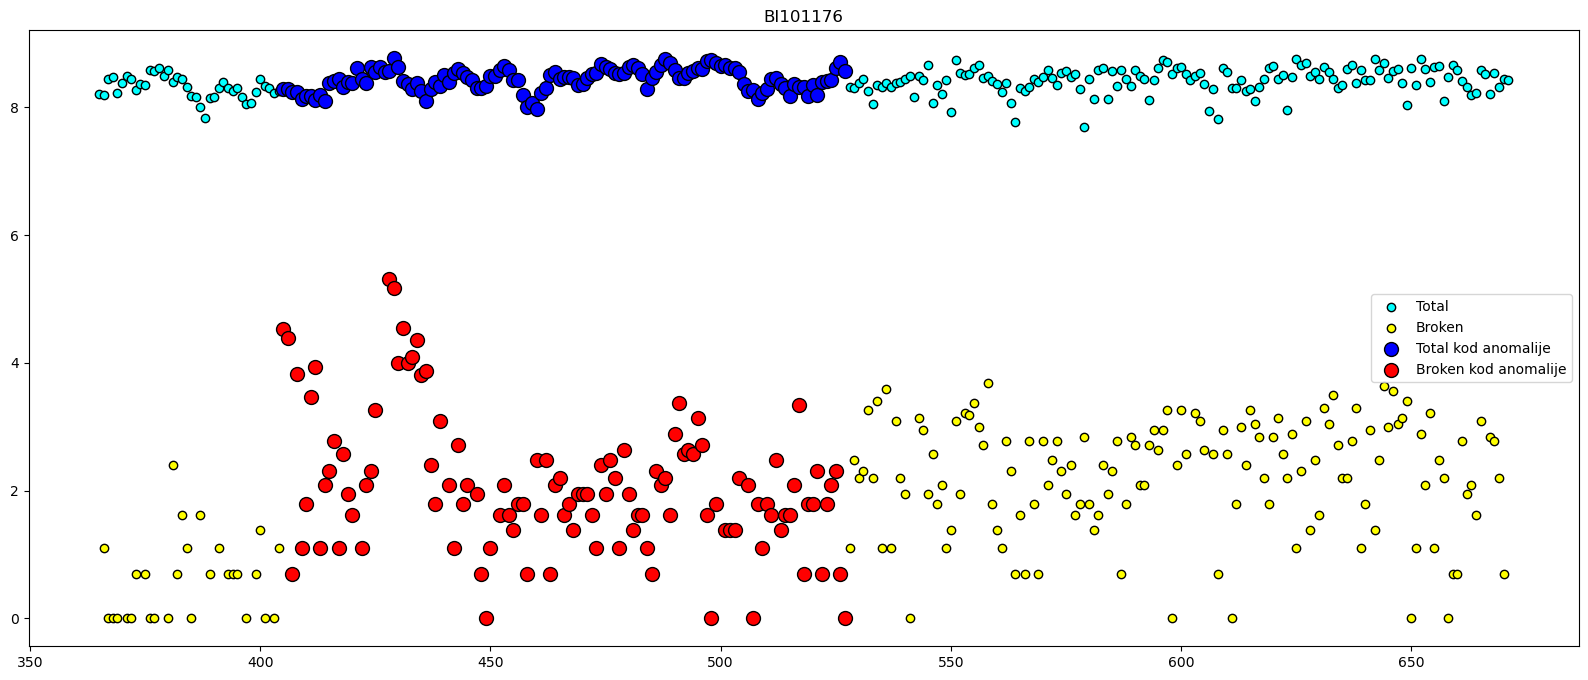

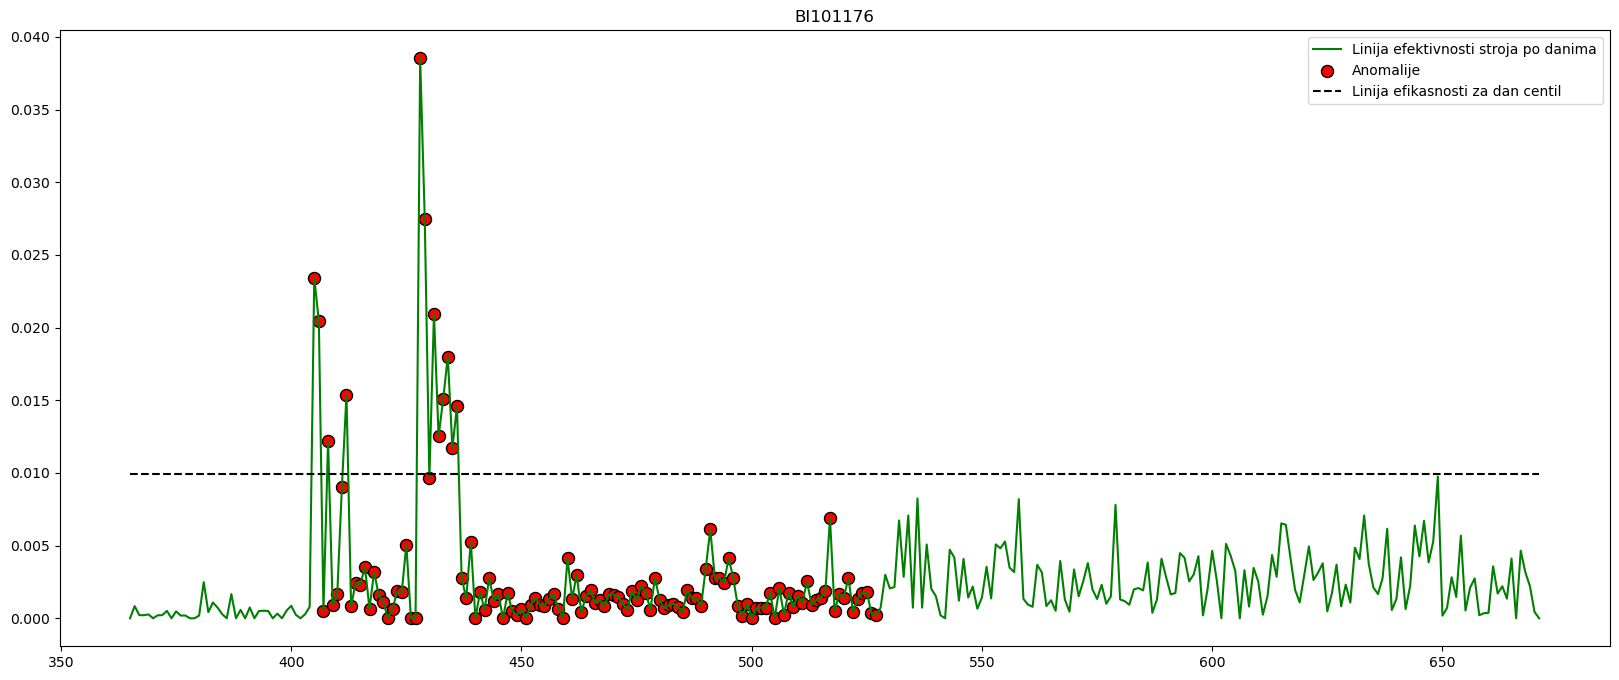

In [17]:
#Nepopravljivost
visualizeData('BS107539')
visualizeEff('BS107539', 0.5)
visualizeData('BI101176')
visualizeEff('BI101176',0.5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log


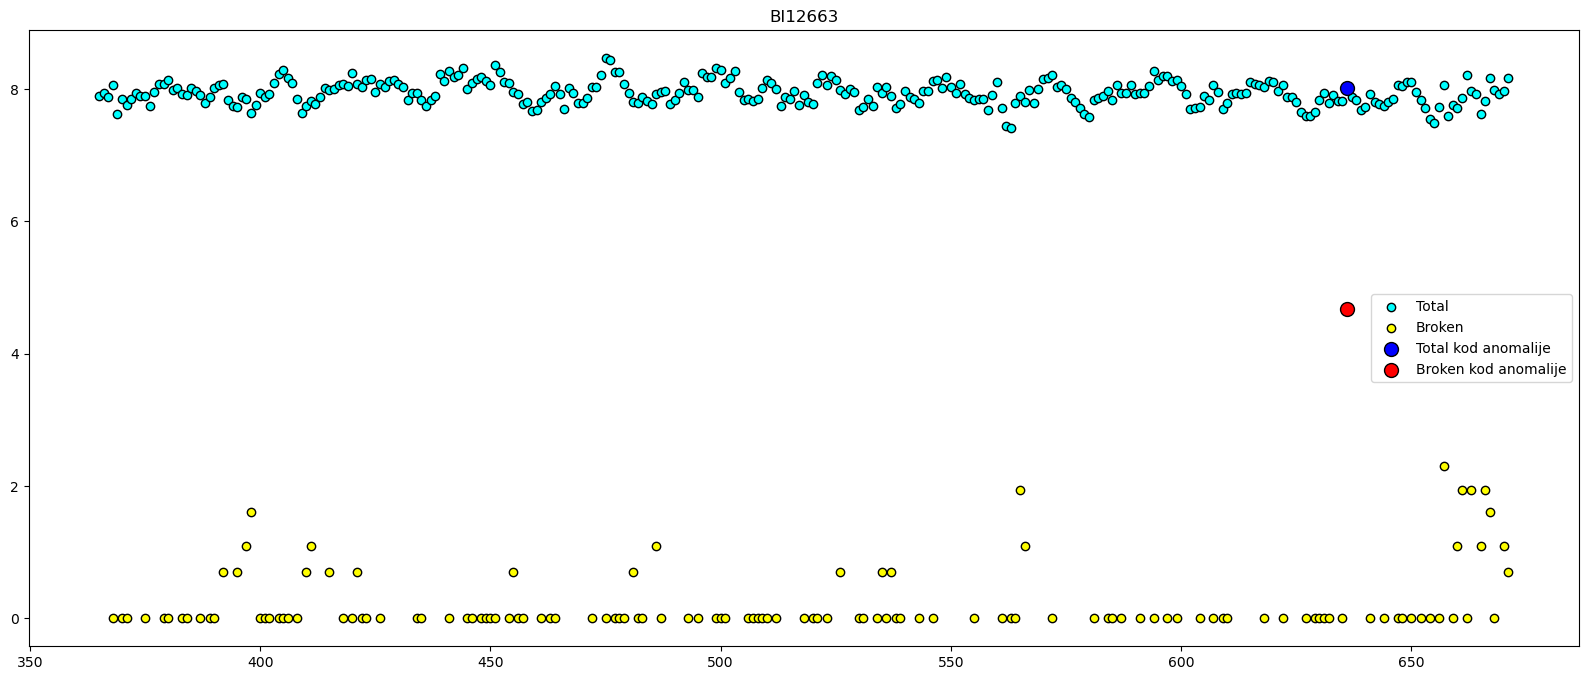

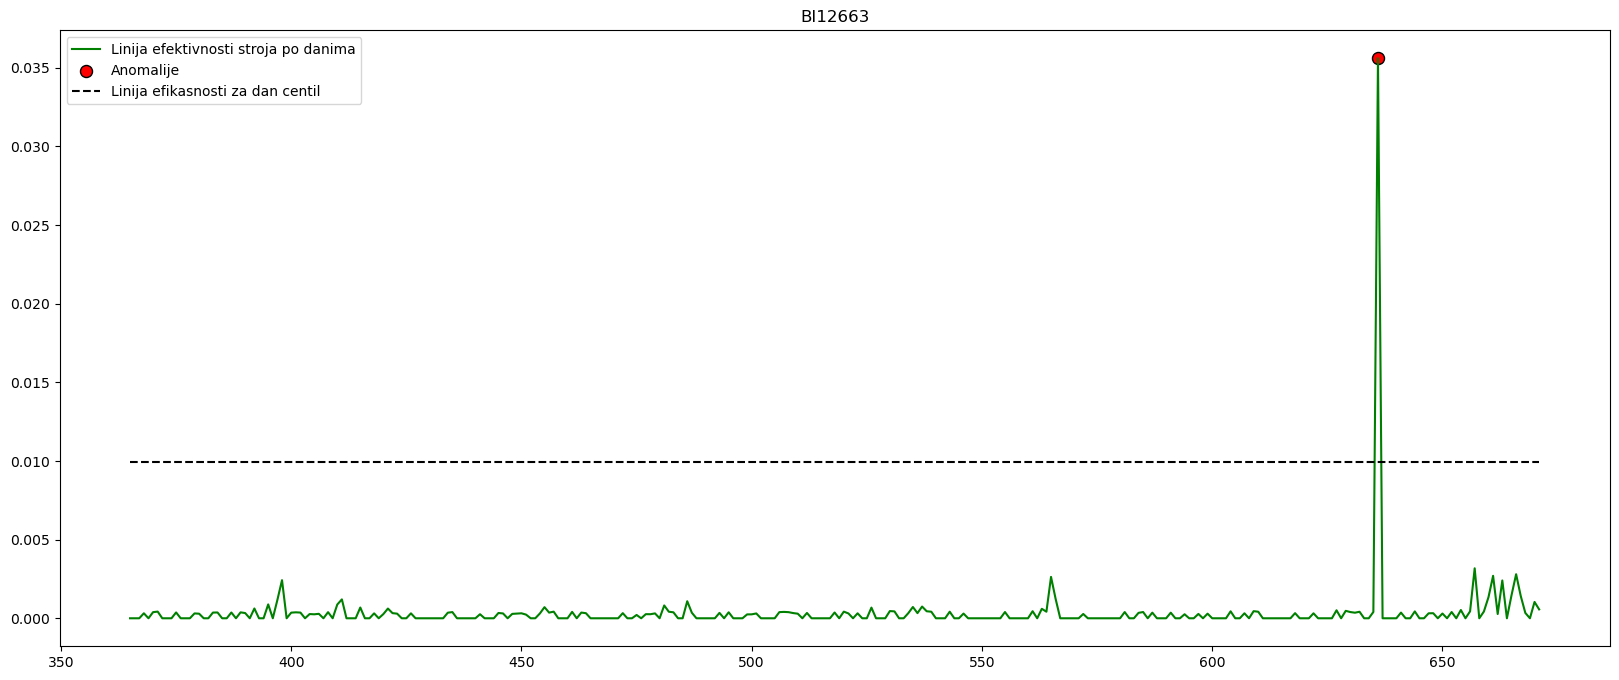

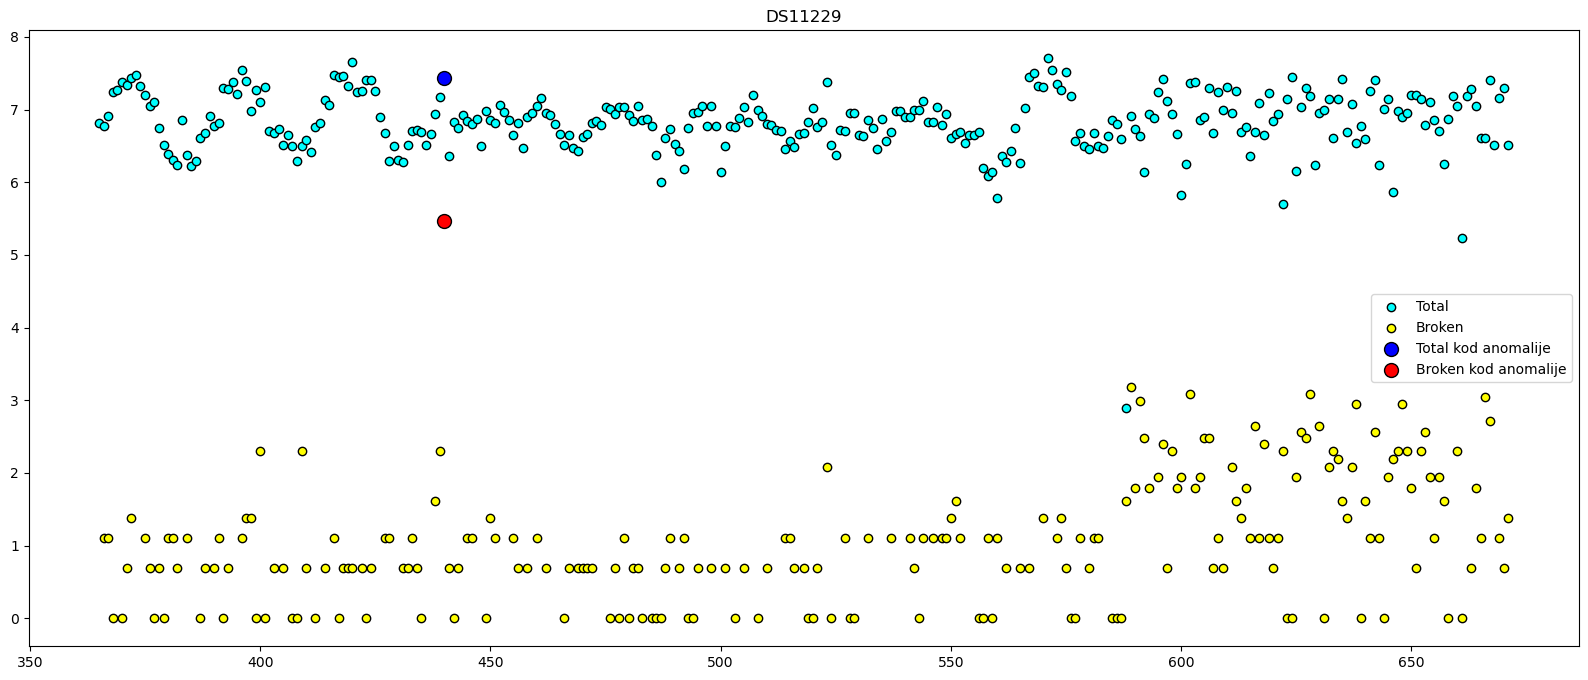

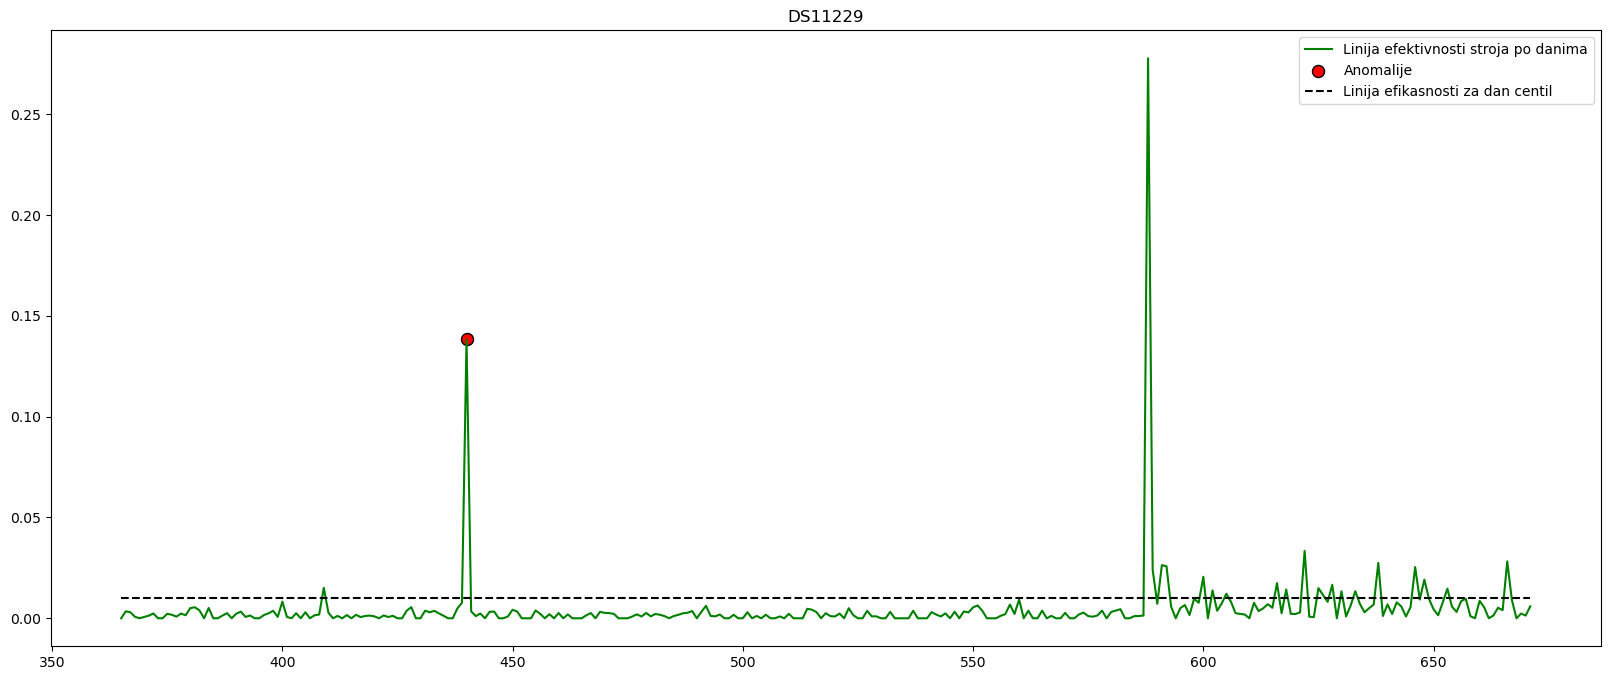

In [18]:
#Obican anomalija
visualizeData('BI12663')
visualizeEff('BI12663', 0.5)
visualizeData('DS11229')
visualizeEff('DS11229',0.5)

# 6. Reference classifier

Tu ću sad pokušati klasificirat podatke iz test skupa podataka sa naučenim k-NN modelom nad ovim train skupom podataka.

In [19]:
X_test=pd.read_csv("/kaggle/input/dapprojekt23/test.csv")
del X_test['id']
del X_test['machine_name']
X_test.head()

,day,broken,total
0,0,0,1413
1,1,3,1546
2,2,0,1608
3,3,6,1682
4,4,0,985


In [204]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X=train.drop(["label", "machine_name"], axis=1)
y=list(train['label'])

X=np.asarray(X)
X_test=np.asarray(X_test)

standardScaler=StandardScaler()
X= standardScaler.fit_transform(X, y)
X_test=standardScaler.transform(X_test)

X=np.asarray(X)
X_test=np.asarray(X_test)

knn = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 15).fit(X, y)
pred = knn.predict(X_test)

In [210]:
submission=pd.read_csv("/kaggle/input/dapprojekt23/test.csv")
submission['Predicted']=pred
del submission['day']
del submission['broken']
del submission['total']
del submission['machine_name']
submission.head()

,id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [211]:
submission.to_csv('submission.csv',index=False)

F1 score ovog modela je 0.50313.